## Image Captioning : part II

#### AhmadReza Nopoush
#### id: 610301194

this paert is completly similiar to previous part exept that the CNN decoder parameters is trainable. so we build the model and test it.


### Step 1
at the begining, we import the libraries we need.

In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
from tqdm.notebook import tqdm


import tensorflow.keras.applications.resnet50
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap

### Step 2: Import DataSet from Kaggle

here we import flickr8k dataset from kaggle as below:

In [2]:
pip install opendatasets

In [3]:
import opendatasets as od
import pandas

od.download("https://www.kaggle.com/datasets/adityajn105/flickr8k/data")


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: ahmadnp
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/adityajn105/flickr8k


100%|██████████| 1.04G/1.04G [00:06<00:00, 164MB/s]


### Step 3
in this step we load the captions, then we edit it in order to tokenize it better. we define `mapping` which is a dictionary that it keys ia a name of each images and its values are the captions of that image.

Now we open caption file...

In [4]:
with open(os.path.join('flickr8k/captions.txt'), 'r') as f:
  #skips the first line
  next(f)
  captions_doc = f.read()

In [5]:
#Create a dictionary of image names to captions

mapping = dict()

for line in tqdm(captions_doc.split('\n')):
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    image_id = image_id.split('.')[0]
    caption = " ".join(caption)
    if image_id not in mapping:
        mapping[image_id] = []
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

the schema of `mapping` you can see as below:

In [6]:
print("length of mapping: ", len(mapping))

length of mapping:  8091


In [7]:
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

### Step 4
in this step we define the `All_Captions`, which is a list of the whole captions that we have. We pass the captions through a filter so that all captions are uniformly converted into a set of pure words. so we define a function `Cleaner` that remove all of the non-Alphabet charecters and replace capital letters to small letters.

In [8]:
def Cleaner(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i]
            caption = caption.lower()
            caption = caption.replace('[^A-Za-z]', '')
            caption = caption.replace('\s+', ' ')
            for char in caption:
              if not char.isalpha() or not char.isspace():
                caption.replace(char,'')
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption


Cleaner(mapping)

In [9]:
All_Captions = list()
for key in mapping:
    for caption in mapping[key]:
        All_Captions.append(caption)

print("the size of all sentences is: ",len(All_Captions))
All_Captions[:10]

the size of all sentences is:  40455


['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

### Step 5:
Now, we define the `tokenize` function. This function assigns a number to each word of all the words we have and returns it as a dictionary. For this, we give the list `All_Captions` we got before as input to the function. The function breaks it into a set of valid words and assigns a number to each member.

Then, we define the `TexttoSeq` function. According to the dictionary we produced, this function assigns a list of numbers to each caption that is input as a string, where each number is the number of the corresponding word in the dictionary.

by this two function we can tokenize the string and give that to the encoder RNN model.

In [10]:
def tokenize(all_captions):
  dictionary = dict()
  dictionary['startseq'] = 1
  dictionary['endseq'] = 2
  flag = 3

  for cap in all_captions:
    capn = cap.split()
    for word in capn:
      word = word.replace('[^A-Za-z]', '')
      word = word.replace('"', '')
      word = word.replace("'", '')
      if len(word) < 2:
        continue
      if word not in dictionary.keys():
        dictionary[word] = flag
        flag += 1

  return dictionary

def TexttoSeq(dictionary, string):
  array = list()

  caption = string.split()
  for word in caption:
    word = word.replace('[^A-Za-z]', '')
    word = word.replace('"', '')
    word = word.replace("'", '')
    if len(word) < 2:
      continue
    if word in dictionary.keys():
      array.append(dictionary[word])

  return array

Tokenized = tokenize(All_Captions)
vocab_size = len(Tokenized)

In [11]:
print("the vocabulary size is: ", vocab_size)

the vocabulary size is:  8884


In [12]:
# maximum length of the caption available
max_length = max(len(caption.split()) for caption in All_Captions)

max_length

35

### Step 6
in this step we divide our dataset into train and test data.

In [13]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

### Step 7: Construct the CNN Encoder
here, we develop the CNN part. as there is no RESNET18 in keras, we used ResNet50 instead. we summarized the model so we can see descreptions of the encoder as below




In [14]:
from tensorflow.keras.applications import ResNet50

model = ResNet50(weights='imagenet')

model.summary()

102967424/102967424 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                    

### Image Processing
here we process all of the images. first, we load each image and conver it to an array with size (224, 224). then we reshape the array in order to be given to CNN decoder. then we give the reshaped array to `model` to extract features from image. then we update the `features` dictionary which the keys are name of an image and the values are the extracted features.

In [15]:
#extract features from image

features = {}
directory = os.path.join('flickr8k/Images')

for img_name in tqdm(os.listdir(directory)):
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = tf.keras.applications.resnet50.preprocess_input(image)
    feature = model.predict(image, verbose=0)
    image_id = img_name.split('.')[0]
    features[image_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

### Step 8
Now we define the `data-generator`. this function helps the model to take the input data (captions) as a list of numbers (with the help of tokenizer we build-up) in batches.

In [16]:
#creating data generator to get data in batch

def data_generator(data_keys, mapping, Tokenized, features, max_length, vocab_size, batch_size):
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            for caption in captions:
                seq = TexttoSeq(Tokenized, caption)
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

#### Encoder RNN Model:
now we build the encoder part. this encoder tries to make relations between the features that we got from CNN decoder and the array of numbers that we tokenized the captios. also we set `loss='categorical_crossentropy', optimizer='adam'` as project asks from us. you can see the plot of encoder as below:

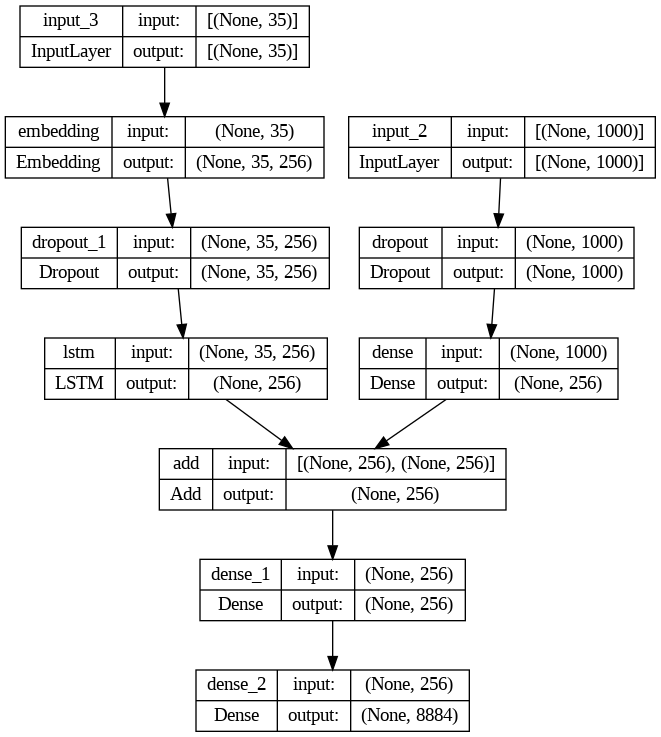

In [17]:
#image feature layers
inputs1 = Input(shape=(1000,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

#sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)


#decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

plot_model(model, show_shapes=True)

### Step 9: Train the model

Now we can train the encoder part of our model

In [18]:
#initializing epochs and batches
epochs = 7
batch_size = 32
steps = len(train) // batch_size

#train the encoder
for i in range(epochs):
    generator = data_generator(train, mapping, Tokenized, features, max_length, vocab_size, batch_size)
    model.fit(generator, epochs=3, steps_per_epoch=steps, verbose=1)

Epoch 1/3
227/227 [==============================] - 71s 277ms/step - loss: 5.7619
Epoch 2/3
227/227 [==============================] - 57s 250ms/step - loss: 4.6469
Epoch 3/3
227/227 [==============================] - 57s 252ms/step - loss: 4.2654
Epoch 1/3
227/227 [==============================] - 56s 246ms/step - loss: 4.0180
Epoch 2/3
227/227 [==============================] - 55s 241ms/step - loss: 3.8317
Epoch 3/3
227/227 [==============================] - 55s 240ms/step - loss: 3.6818
Epoch 1/3
227/227 [==============================] - 54s 240ms/step - loss: 3.5552
Epoch 2/3
227/227 [==============================] - 54s 239ms/step - loss: 3.4459
Epoch 3/3
227/227 [==============================] - 55s 243ms/step - loss: 3.3504
Epoch 1/3
227/227 [==============================] - 57s 249ms/step - loss: 3.2636
Epoch 2/3
227/227 [==============================] - 53s 236ms/step - loss: 3.1843
Epoch 3/3
227/227 [==============================] - 54s 237ms/step - loss: 3.1111
Epoc

### Step 10:
in the last step we define three functions:
1. `idx_to_word`: this function just reversley convert a list of array to a sentence(caption) by using the `Tokenized` dictionary.

2. `prdict_caption`: this function gave the model the name of images, and the model give an array of numbers back. then this function turn this array to string and return it, which is an expected captions.

3. `generate_captins`: this function simply get the name of image, then show its captions and the caption that model predict, then it plot the image so we can judge the model.

In [19]:
def idx_to_word(integer, Tokenized):
    for word, index in Tokenized.items():
        if index == integer:
            return word
    return None

In [20]:
#generate caption for an image
def predict_caption(model, image, Tokenized, max_length):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = TexttoSeq(Tokenized, in_text)
        sequence = pad_sequences([sequence], max_length)
        yhat = model.predict([image, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idx_to_word(yhat, Tokenized)
        if word is None:
            break
        in_text += " " + word
        if word == 'endseq':
            break

    return in_text

In [21]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):

    image_id = image_name.split('.')[0]
    img_path = os.path.join("flickr8k/Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)

    y_pred = predict_caption(model, features[image_id], Tokenized, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)
    plt.axis('off')

### Step 11: Test the model on test data!
Now after training we can test our model on unseen images:

---------------------Actual---------------------
startseq hiker treks up the snowy mountain endseq
startseq man climbing snowy mountain endseq
startseq man skiing in the mountains endseq
startseq mountaineer is ascending snow covered trail whilst attached to rope endseq
startseq person in blue hat climbing up snow covered mountain endseq
--------------------Predicted--------------------
startseq man is climbing up snowy mountain endseq


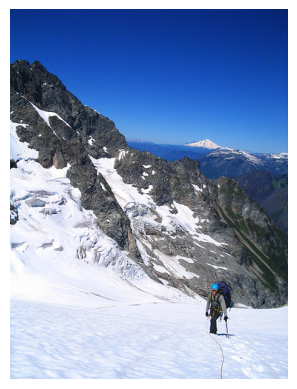

In [25]:
ri1 = np.random.randint(0,len(test)-1)
generate_caption(test[ri1]+'.jpg')

---------------------Actual---------------------
startseq bearded man wearing denim jacket and hat sits on park bench endseq
startseq bearded man wearing denim jacket sits on bench endseq
startseq man with bushy beard and baseball cap sits on park bench endseq
startseq an old man with long beard and jean jacket sits on park bench endseq
startseq "an old man with long white beard glasses and hat is sitting on park bench ." endseq
--------------------Predicted--------------------
startseq man wearing red shirt and white shirt is walking on the side of the road endseq


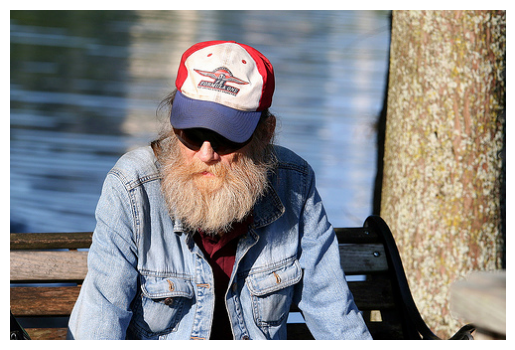

In [26]:
ri2 = np.random.randint(0,len(test)-1)
generate_caption(test[ri2]+'.jpg')

---------------------Actual---------------------
startseq baseball player standing on the field endseq
startseq baseball player stands and faces the crowd endseq
startseq baseball player wearing number 19 shirt looks at the outfield endseq
startseq male ballplayer wearing white and blue uniform playing in front of large crowd endseq
startseq baseball player looking out into stadium crowd endseq
--------------------Predicted--------------------
startseq baseball player in red uniform and white uniform dodges the ball endseq


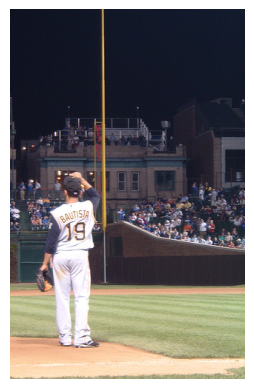

In [27]:
ri3 = np.random.randint(0,len(test)-1)
generate_caption(test[ri3]+'.jpg')

---------------------Actual---------------------
startseq dark skinned man walks by woman talking on cellphone endseq
startseq male walking and female talking on the phone beside the concrete building endseq
startseq people stand outside near concrete wall and window endseq
startseq two people standing on the sidewalk endseq
startseq "two women one carrying purse and papers are standing on sidewalk ." endseq
--------------------Predicted--------------------
startseq man in black shirt and white shirt is walking down the street endseq


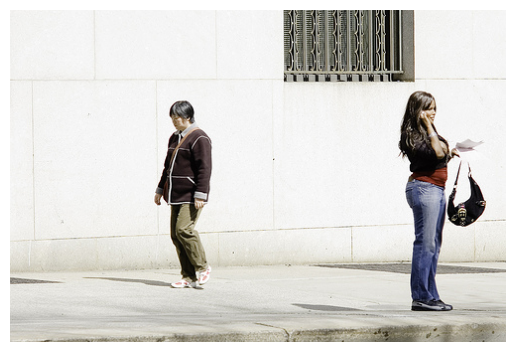

In [28]:
ri4 = np.random.randint(0,len(test)-1)
generate_caption(test[ri4]+'.jpg')

### Conclusion: a comparison

Similiar to previous part as we can see from the results, most of the time, the model has the ability to recognize the main components or features of the image. But it works poorly in analyzing the details of the image, and this makes the generated sentence look a little wrong or funny. This shows that first, the CNN decoder part of model works well; Because it recognizes the features correctly. But probably the RNN encoder part works poorly, which may be due to poor tokenization or even the model is not trained well enough.

Compared to the model of the previous part, we see that the model performs wrongly in recognizing some features, which is a sign of a change in the model's CNN decoder.

As a result, it can be said that if the parameters of CNN decoder is trainable, then the model will be weak in recognizing some features, but instead will give more coordination power with the RNN encoder part.